In [1]:
import emcee
import george
import corner
import numpy as np
import pandas as pd
import astropy.io.fits as fits
import matplotlib.pyplot as plt

from george import kernels
from george.modeling import Model
from scipy.optimize import minimize
from astropy.timeseries import LombScargle

# --- Imports
import copy
import radvel
import george
import pypolychord

import numpy as np
from george import kernels
from pypolychord.settings import PolyChordSettings

import prior_transforms as pt
from pickle_data import load_data_from_pickle

# --- Parameter configuration
INCLUDE_PLANET_B = False

# --- Output directory
output_dir = "L98_59_aldo/polychord_out"
cluster_dir = "L98_59_aldo/polychord_out/clusters"

# --- Import relevant data
pickle_file_path = "../datasets/cleaned_data_20240531.pickle"
X = load_data_from_pickle(pickle_file_path)
X_pre, X_post, X_harps = X["ESPRESSO_pre"], X["ESPRESSO_post"], X["HARPS"]
n_pre, n_post, n_harps = len(X_pre["RV"]), len(X_post["RV"]), len(X_harps["RV"])

In [2]:
ESPRESSO_df = pd.concat([X_pre, X_post], ignore_index=True)
ESPRESSO_times = np.block([X_pre["Time"], X_post["Time"]])
HARPS_df = X_harps
HARPS_times = X_harps["Time"]
time = np.concatenate([ESPRESSO_times, HARPS_times])

In [3]:
min_frequency = 1 / (time.max() - time.min())  # Longest period
max_frequency = 1 / (2 * np.median(np.diff(time)))  # Nyquist frequency

print(f'Minimum frequency: {min_frequency:}')
print(f'Maximum frequency: {max_frequency:}')

Minimum frequency: 0.0019167233230466848
Maximum frequency: 0.5052102331671597


## ESPRESSO

In [4]:
# Extract data
activity_indices = ['RV', 'FWHM', 'BIS', 'Sindex', 'NaD', 'Halpha', 'Contrast']

# Determine the frequency range days
# min_frequency = 1 / (time.max() - time.min())  # Longest period
min_frequency = 0.002025227467386652 # min frequency ESPRESSO
#min_frequency = 0.0036063525167432157
max_frequency = 0.5177264355163222   # max frequency HARPS
samples_per_peak = 3000

# convert frequency to microhertz
def convert_to_microhertz(frequency_in_days):
    return frequency_in_days * 1e6 / 86400

# convert microhertz to frequency
def convert_to_days(frequency_in_microhertz):
    return frequency_in_microhertz * 86400 / 1e6

# Perform the Lomb-Scargle periodogram
def compute_periodogram(time, data, min_frequency=min_frequency, max_frequency=max_frequency, samples_per_peak=samples_per_peak):

    frequency, power = LombScargle(time, data).autopower(
        minimum_frequency=min_frequency,
        maximum_frequency=max_frequency,
        normalization='standard',
        samples_per_peak=samples_per_peak
        )
    return frequency, power

# Compute periodograms
periodograms = {}
for index in activity_indices:
    frequency, power = compute_periodogram(ESPRESSO_times, ESPRESSO_df[index], min_frequency, max_frequency)
    periodograms[index] = (frequency, power)

# Compute the window function
observation_indicator = np.ones_like(ESPRESSO_times)
window_power = LombScargle(ESPRESSO_times, observation_indicator).power(frequency)
periodograms['WF'] = (frequency, window_power)  # Add the window function to the periodograms

def frequency_to_period(frequency):
    # Assuming frequency is in microhertz, convert to period in days
    return 1 / (frequency * 86400 * 1e-6)


freqSi, powSi = periodograms['Sindex']

In [14]:
import numpy as np
from scipy.signal import find_peaks, peak_widths

def frequency_to_period(freq, freq_uncertainty):
    # Calculate the period
    period = 1 / freq

    # Calculate the uncertainty in the period
    period_uncertainty = freq_uncertainty / (freq ** 2)

    return period, period_uncertainty

def analyze_periodogram(freq, power):
    # Find peaks; adjust parameters as needed for your data
    peaks, properties = find_peaks(power, height=0)
    
    # Extract peak heights and corresponding frequencies
    peak_heights = properties['peak_heights']
    peak_freqs = freq[peaks]
    
    # Sort peaks by height in descending order
    sorted_indices = np.argsort(peak_heights)[::-1]
    sorted_peaks = peak_freqs[sorted_indices]
    sorted_heights = peak_heights[sorted_indices]
    
    # Calculate widths at half maximum height for all peaks
    results_half = peak_widths(power, peaks, rel_height=0.5)
    
    # Prepare result dictionary
    results = {}
    
    # Get the largest peak
    if len(sorted_peaks) > 0:
        largest_peak_freq = sorted_peaks[0]
        largest_peak_power = sorted_heights[0]
        largest_peak_width = results_half[0][sorted_indices[0]]  # width in index units
        largest_peak_width_freq = np.diff(freq)[0] * largest_peak_width  # convert width index to frequency space
        largest_peak_uncertainty = largest_peak_width_freq / 2
        
        results['largest_peak'] = {
            'frequency': largest_peak_freq,
            'power': largest_peak_power,
            'uncertainty': largest_peak_uncertainty
        }
    
    # Get the second largest peak
    if len(sorted_peaks) > 1:
        second_peak_freq = sorted_peaks[1]
        second_peak_power = sorted_heights[1]
        second_peak_width = results_half[0][sorted_indices[1]]
        second_peak_width_freq = np.diff(freq)[0] * second_peak_width
        second_peak_uncertainty = second_peak_width_freq / 2
        
        results['second_peak'] = {
            'frequency': second_peak_freq,
            'power': second_peak_power,
            'uncertainty': second_peak_uncertainty
        }
    
    return results

freqSi, powSi = periodograms['Sindex']

# Analyze the periodogram
results = analyze_periodogram(freqSi, powSi)

period1, period1_uncertainty = frequency_to_period(results['largest_peak']['frequency'], results['largest_peak']['uncertainty'])
period2, period2_uncertainty = frequency_to_period(results['second_peak']['frequency'], results['second_peak']['uncertainty'])

# Print results period units
if 'largest_peak' in results:
    print(f'Largest peak: {period1:.2f} +/- {period1_uncertainty:.2f} days')

if 'second_peak' in results:
    print(f'Second peak: {period2:.2f} +/- {period2_uncertainty:.2f} days')



Largest peak: 99.87 +/- 9.26 days
Second peak: 78.22 +/- 4.56 days


In [24]:
1/0.012784585925789474

78.21919347288113

In [32]:
# Peak value and uncertainty

freqSi, powSi = periodograms['Sindex']

max_idx = np.argmax(powSi)
peak_freq = freqSi[max_idx]
peak_pow = powSi[max_idx]


1/peak_freq

99.88638475990716

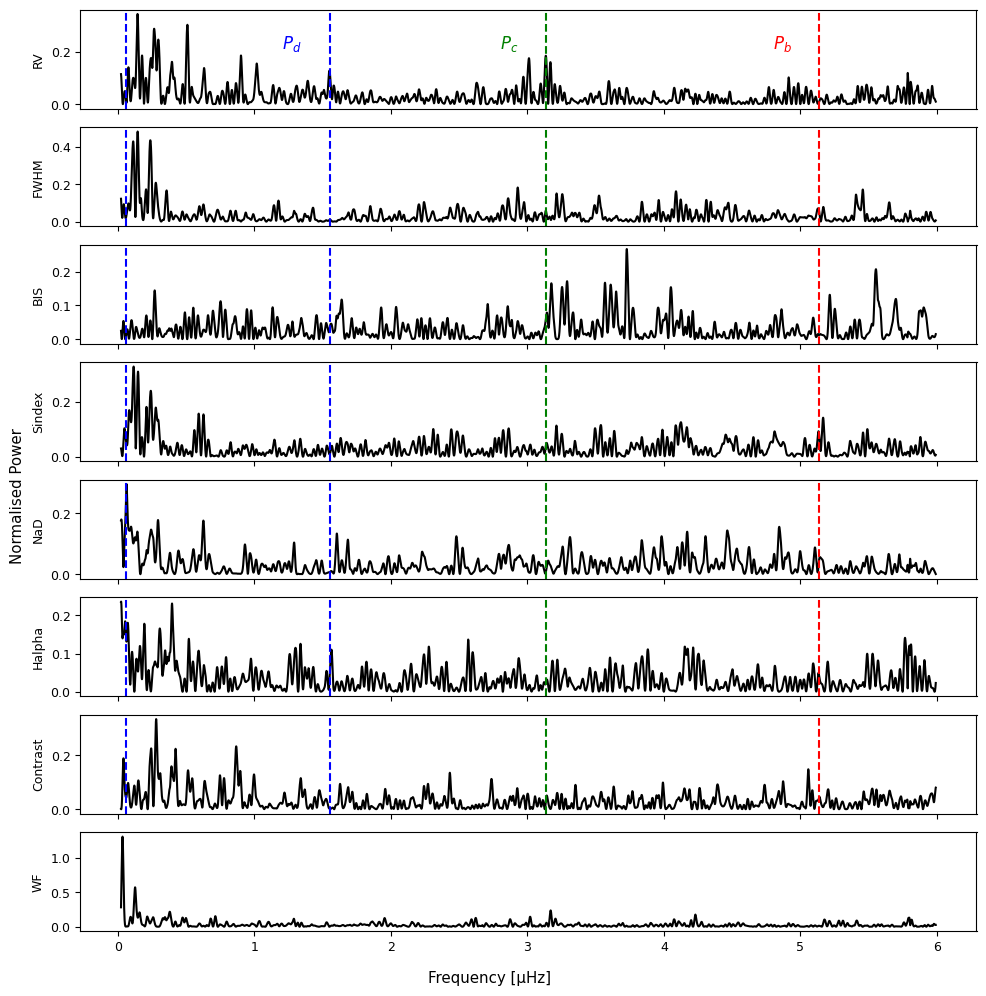

In [7]:
# True values (accoridng to paper (D. S. Demangeon et al. 2021))
true_periods = [2.2531136, 3.6906777,  7.4507245, 200]
period_colors = ['red', 'green', 'blue', 'blue']  # Define more colors if there are more true periods

# Plotting
fig, axes = plt.subplots(len(periodograms), 1, figsize=(10, 10), sharex=True)

colors = ['b', 'g', 'c']  # Extend this list if you have more than six lines

for i, (ax, (key, (frequency, power))) in enumerate(zip(axes, periodograms.items())):
    # Plot each line in a different color
    frq = convert_to_microhertz(frequency)
    frq_linspace = np.linspace(frq.min(), frq.max(), 100000)
    ax.plot(frq, power, color='black', label=key)
    ax.set_ylabel(key)
    if i < len(axes) - 1:
        for peak, color in zip(true_periods, period_colors):
            ax.axvline(x=convert_to_microhertz(1 / peak), color=color, linestyle='--', label=f'True Period: {peak} days')

    if i == 0:
        ax.text(1.2, 0.27, r'$P_d$', color='b', verticalalignment='top', size=12)
        ax.text(2.8, 0.27, r'$P_c$', color='g', verticalalignment='top', size=12)
        ax.text(4.80, 0.27, r'$P_b$', color='r', verticalalignment='top', size=12)
        

# common axis labels
fig.supxlabel('Frequency [µHz]')
fig.supylabel('Normalised Power')


plt.tight_layout()
plt.show()

In [9]:
# Extract data
time = HARPS_times
activity_indices = ['RV', 'FWHM', 'BIS', 'Sindex', 'NaD', 'Halpha', 'Hbeta', 'Hgamma']

# Determine the frequency range
# min_frequency = 0.002025227467386652 # min frequency ESPRESSO
# (0.005187477566099779 + 0.002025227467386652) / 2 = 0.0036063525167432157
min_frequency = 0.0036063525167432157  # min frequency HARPS
max_frequency = 0.5177264355163222   # max frequency HARPS
samples_per_peak = 10
normalization = 'standard'

# convert frequency to microhertz
def convert_to_microhertz(frequency_in_days):
    return frequency_in_days * 1e6 / 86400

# Perform the Lomb-Scargle periodogram
def compute_periodogram(time, data, min_frequency=min_frequency, max_frequency=max_frequency, normalization=normalization, samples_per_peak=samples_per_peak):

    frequency, power = LombScargle(time, data).autopower(
        minimum_frequency=min_frequency,
        maximum_frequency=max_frequency,
        normalization=normalization,
        samples_per_peak=samples_per_peak
    )
    return frequency, power

# Compute periodograms
periodograms = {}
for index in activity_indices:
    frequency, power = compute_periodogram(time, HARPS_df[index], min_frequency, max_frequency)
    periodograms[index] = (frequency, power)

# Compute the window function
observation_indicator = np.ones_like(time)
window_power = LombScargle(time, observation_indicator).power(frequency)
periodograms['WF'] = (frequency, window_power)  # Add the window function to the periodograms


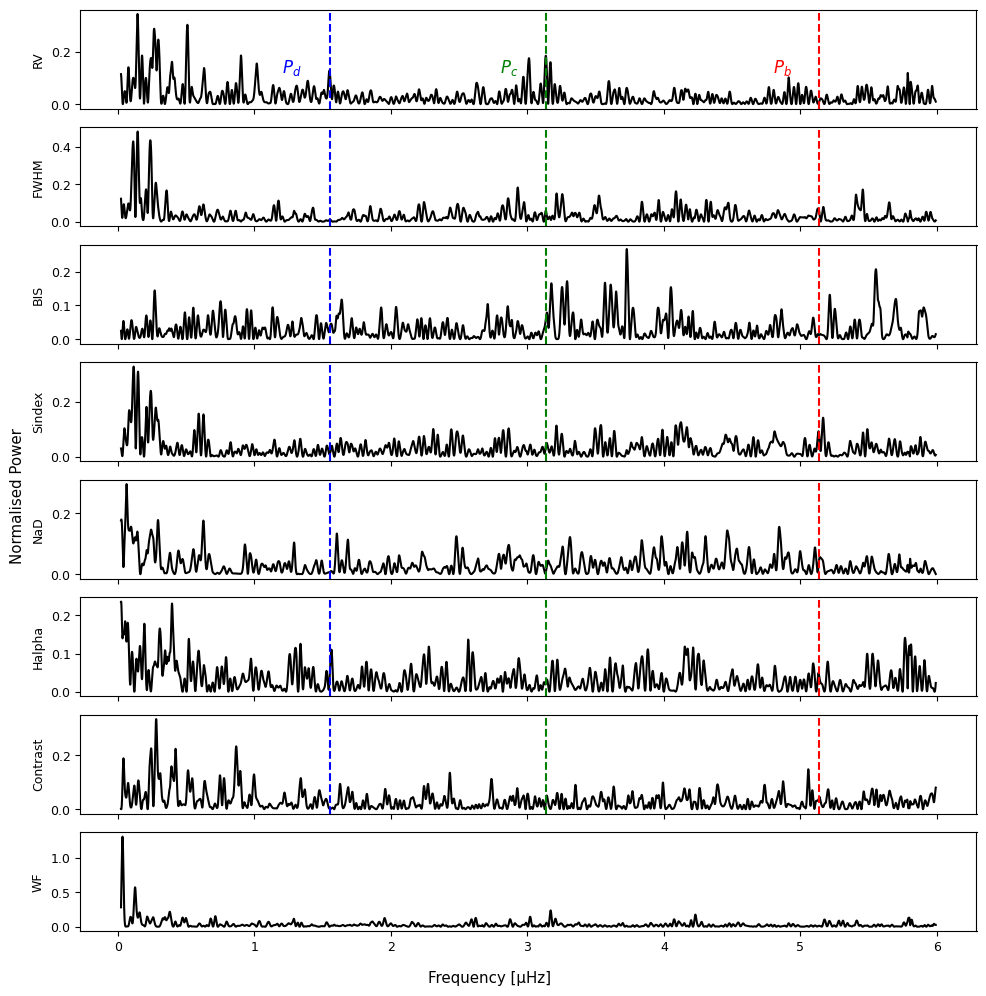

In [42]:
# True values (accoridng to paper (D. S. Demangeon et al. 2021))
true_periods = [2.2531136, 3.6906777,  7.4507245]
period_colors = ['red', 'green', 'blue']  # Define more colors if there are more true periods

# Plotting
fig, axes = plt.subplots(len(periodograms), 1, figsize=(10, 10), sharex=True)

colors = ['b', 'g', 'c', 'm', 'y', 'k']  # Extend this list if you have more than six lines

for i, (ax, (key, (frequency, power))) in enumerate(zip(axes, periodograms.items())):
    # Plot each line in a different color
    ax.plot(convert_to_microhertz(frequency), power, color='black', label=key)
    ax.set_ylabel(key)
    if i < len(axes) - 1:
        for peak, color in zip(true_periods, period_colors):
            ax.axvline(x=convert_to_microhertz(1 / peak), color=color, linestyle='--', label=f'True Period: {peak} days')

    if i == 0:
        ax.text(1.2, 0.18, r'$P_d$', color='b', verticalalignment='top', size=12)
        ax.text(2.8, 0.18, r'$P_c$', color='g', verticalalignment='top', size=12)
        ax.text(4.80, 0.18, r'$P_b$', color='r', verticalalignment='top', size=12)

# common axis labels
fig.supxlabel('Frequency [µHz]')
fig.supylabel('Normalised Power')

plt.tight_layout()
plt.show()